In [1]:
#We load in the specific data needed
import polars as pl
import numpy as np
import os
from pathlib import Path
import pandas as pd
from datetime import date
import datetime
import hvplot.polars
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import bisplrep, bisplev
from datetime import timedelta
from patsy import dmatrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
from sklearn.model_selection import ParameterGrid  # 
from keras.optimizers import RMSprop
import statsmodels.api as sm

In [2]:
# data_nor = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_train_tech_nonscaled.parquet')
# datat_nor = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_test_tech_nonscaled.parquet')

data = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_train_val_tech_standardized_filter.parquet')
datat = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_test_tech_scaled_all_sso_filter.parquet')

# prc_filter = 0.125

impl_volatility = 'impl_volatility_h_1_step'
# data_nor = data_nor[data_nor['prc_option'] >= prc_filter]
# datat_nor = datat_nor[datat_nor['prc_option'] >= prc_filter]

test_data = datat[datat['date'] >= '2021-01-01']
total_train = data[data['date'] < '2021-01-01']

# # data_sso = data_sso[data_sso['prc_option'] > prc_filter]
# # datat_sso = datat_sso[datat_sso['prc_option'] > prc_filter]

basic = ['moneyness', 'T', 'moneyness_squared', 'tau_squared', 'moneyness_tau']
option_specific = ['spread_option', 'volume', 'prc_option', 'previous_iv', 'previous_iv_all']
macro_features = ['1Y_bond','2Y_bond','FF_rate', 'gold_price','reces_indi','10Y_RIR', 'CLOSE_vix', 'hi-lo_vix']
stock_specific = ['BID', 'ASK', 'daily_return_indicator_stock', '5_day_rolling_return_stock', 'hi-lo_stock', ]

tickers = ['ticker_AAPL', 'ticker_AMZN', 'ticker_META', 'ticker_MSFT','ticker_NVDA', 'ticker_TSLA'  ]

totalList = basic + macro_features + option_specific + stock_specific + tickers 

totalList = ['T',
 'moneyness',
 'previous_iv',
 'spread_option',
 '2Y_bond',
 'RET',
 'cp_flag',
 'ticker_TSLA',
 'ticker_AMZN']

# totalList = ['moneyness', 'T'] + macro_features + option_specific + stock_specific + tickers


totalList_standardize = totalList + ['impl_volatility', 'date', 'ticker']


# data_train = data_trains[data_trains['date'] < '2020-01-01']
# data_validate = data_trains[data_trains['date'] >= '2020-01-01']

In [3]:
data

,date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,...,total_iv_weighted,previous_iv,previous_iv_all,ticker_AAPL,ticker_AMZN,ticker_META,ticker_MSFT,ticker_NVDA,ticker_TSLA,Ticker
591,2019-01-02,1,0.098562,0.217804,0.216556,-0.288939,-0.378934,0.443137,1.184709,-0.170676,...,-0.129035,-0.037083,-0.255027,0,1,0,0,0,0,AMZN
592,2019-01-02,1,0.100937,0.172531,0.172293,0.677096,0.139223,0.443124,1.132191,-0.173316,...,0.764231,-0.037083,-0.255027,0,1,0,0,0,0,AMZN
593,2019-01-02,1,0.103312,0.129415,0.128029,-0.275877,-0.362011,0.442606,1.079918,-0.176368,...,-0.123558,-0.037083,-0.255027,0,1,0,0,0,0,AMZN
594,2019-01-02,1,0.105687,0.088454,0.087981,-0.243724,-0.353051,0.442704,1.028717,-0.180575,...,-0.100976,-0.037083,-0.255027,0,1,0,0,0,0,AMZN
595,2019-01-02,1,0.108062,0.049649,0.050041,-0.303580,-0.369477,0.442872,0.978405,-0.185525,...,-0.150998,-0.037083,-0.255027,0,1,0,0,0,0,AMZN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258424,2020-12-31,0,-1.172061,-0.463440,-0.472270,0.073504,0.181532,0.273027,-0.219229,0.154063,...,-0.169922,-0.820790,-0.513934,0,0,0,1,0,0,MSFT
258425,2020-12-31,0,-1.169686,-0.457403,-0.466368,-0.080804,0.013541,0.253881,-0.312013,0.427449,...,-0.170646,-0.820790,-0.513934,0,0,0,1,0,0,MSFT
258427,2020-12-31,0,-1.167311,-0.447055,-0.455829,0.016230,0.184518,0.238284,-0.460842,0.804653,...,-0.166682,-0.820790,-0.513934,0,0,0,1,0,0,MSFT
258428,2020-12-31,0,-1.174436,-0.467320,-0.476064,0.019675,0.065556,0.292736,-0.158219,-0.036499,...,-0.171519,-0.820790,-0.513934,0,0,0,1,0,0,MSFT


In [21]:
mean_values = data.drop(columns=['date', 'Ticker']).mean()
std_values = data.drop(columns=['date', 'Ticker']).std()
print("Mean values:")
print(mean_values)
print("\nStandard Deviation values:")
print(std_values)
print("\n" + "-"*50 + "\n")

Mean values:
cp_flag                         4.518541e-01
strike_price                    1.012250e-16
best_bid                        4.567472e-17
best_offer                     -8.347980e-17
volume                          7.406711e-18
open_interest                  -6.789485e-18
impl_volatility                 5.853735e-01
delta                           1.666510e-17
gamma                          -8.409703e-17
vega                            2.493593e-16
theta                           4.999530e-17
prc_option                      1.398017e-16
PRC                            -2.456559e-16
PRC_actual                     -3.950246e-16
Year                            2.204533e-13
Annual_Dividend_Yield           7.329558e-17
T                               1.027681e-16
2Y_bond                        -4.937807e-17
Forward_Price                  -1.370241e-16
moneyness                       1.014102e-15
trading_day                     2.073879e-16
moneyness_squared              -4.342184e-

In [5]:
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import ParameterGrid
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# from tensorflow.keras.callbacks import EarlyStopping
# import joblib

# # Define your neural network model creation function
# def create_model(input_dim, neurons=32, layers=1, dropout_rate=0.0):
#     model = tf.keras.Sequential()
#     model.add(tf.keras.layers.Input(shape=(input_dim,)))
    
#     for layer in range(layers):
#         # Halve the neuron count with each layer, starting from the initial `neurons` value
#         neurons_in_layer = max(1, neurons // (2 ** layer))
#         model.add(tf.keras.layers.Dense(neurons_in_layer, activation='relu'))
#         model.add(tf.keras.layers.Dropout(dropout_rate))
    
#     model.add(tf.keras.layers.Dense(1, activation='linear'))
#     model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
#                   loss='mean_squared_error',
#                   metrics=['mse'])
#     return model

# def evaluate_params(params, train_x, train_y, val_data, input_dim, IV, selected_features, verbose=0):
#     """
#     Perform walk-forward validation for a single set of hyperparameters.
#     """
#     if verbose >= 1:
#         print(f"\nEvaluating parameters: {params}")

#     # Create and compile a model with the current parameters
#     model = create_model(
#         input_dim=input_dim,
#         neurons=params['neurons'],
#         layers=params['layers'],
#         dropout_rate=params['dropout_rate']
#     )

#     # Setup early stopping
#     early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

#     current_train_data_x = train_x.copy()
#     current_train_data_y = train_y.copy().reshape(-1, 1)  # Ensure train_y is 2D
#     total_rmse = 0
#     count = 0

#     for date in pd.date_range(start='2020-01-01', end='2020-12-31'):
#         # Filter validation data for the current day
#         val_data_day = val_data[val_data['date'] == date]
#         if val_data_day.empty:
#             continue

#         # Separate features and target for validation
#         y_val = val_data_day[IV].values.reshape(-1, 1)  # Ensure y_val is 2D
#         X_val = val_data_day[selected_features].values  # Convert to NumPy array to avoid warnings

#         # Check for empty training or validation data
#         if current_train_data_x.size == 0 or current_train_data_y.size == 0 or X_val.size == 0 or y_val.size == 0:
#             print(f"Warning: Empty data detected for date {date}. Skipping iteration.")
#             continue

#         # Fit a new scaler on the current training data
#         scaler = MinMaxScaler(feature_range=(-1, 1))
#         current_train_data_x_scaled = scaler.fit_transform(current_train_data_x)  # Ensure NumPy array format
#         X_val_scaled = scaler.transform(X_val)  # Transform validation data

#         # Convert current training data to tf.data.Dataset
#         train_ds = tf.data.Dataset.from_tensor_slices((current_train_data_x_scaled, current_train_data_y))
#         train_ds = train_ds.batch(params['batch_size']).prefetch(tf.data.AUTOTUNE)

#         # Train the model on current training data with the specified parameters
#         if verbose >= 1:
#             print(f"Training model for date {date.date()} - Training data size: {current_train_data_x.shape[0]}")

#         model.fit(
#             train_ds,
#             epochs=params['epochs'],
#             verbose=0,
#             callbacks=[early_stopping]
#         )

#         # Predict on validation set for the current day
#         y_pred = model.predict(X_val_scaled).flatten()
#         rmse = np.sqrt(mean_squared_error(y_val, y_pred))
#         total_rmse += rmse
#         count += 1

#         if verbose >= 1:
#             print(f"  Date: {date.date()}, Validation data size: {X_val.shape[0]}, RMSE: {rmse:.4f}")

#         # Add the current day's validation data to the training set for the next iteration
#         current_train_data_x = np.vstack([current_train_data_x, X_val])  # Ensure consistent NumPy array format
#         current_train_data_y = np.concatenate([current_train_data_y, y_val])

#     # Average RMSE for this parameter combination
#     avg_rmse = total_rmse / count
#     if verbose >= 1:
#         print(f"Finished evaluating parameters: {params}, Average RMSE: {avg_rmse:.4f}")

#     return params, avg_rmse

# def walk_forward_validation_tuning_nn(IV, data, selected_features, param_grid, verbose=0):
#     """
#     Perform Walk-Forward Validation for NN hyperparameter tuning without parallel processing.
#     """
#     if verbose >= 1:
#         print("Starting walk-forward validation tuning for neural network...")

#     # Split the data into training (2019) and validation (2020)
#     train_data = data[data['date'].dt.year == 2019]
#     val_data = data[data['date'].dt.year == 2020]

#     # Define features and target
#     train_x = train_data[selected_features].values  # Ensure NumPy array
#     train_y = train_data[IV].values.reshape(-1, 1)  # Ensure train_y is 2D and a NumPy array

#     input_dim = train_x.shape[1]

#     # Loop through each parameter combination
#     best_score = float('inf')
#     best_params = None

#     for params in ParameterGrid(param_grid):
#         _, avg_rmse = evaluate_params(params, train_x, train_y, val_data, input_dim, IV, selected_features, verbose)

#         # Update best parameters based on RMSE
#         if avg_rmse < best_score:
#             best_score = avg_rmse
#             best_params = params

#             if verbose >= 1:
#                 print(f"  New best parameters found: {best_params} with RMSE: {best_score:.4f}")

#     print(f"Best hyperparameters found: {best_params} with average RMSE: {best_score:.4f}")
#     return best_params, scaler

# def retrain_final_model(IV, data, selected_features, best_params, scaler, verbose=0):
#     """
#     Retrain the final model on combined 2019 and 2020 data with best parameters.
#     """
#     if verbose >= 1:
#         print("Retraining final model on combined 2019 and 2020 data with best parameters...")

#     # Combine training and validation data (2019 and 2020)
#     combined_data = data[data['date'].dt.year <= 2020]
#     combined_x = combined_data[selected_features].values  # Ensure NumPy array
#     combined_y = combined_data[IV].values.reshape(-1, 1)  # Ensure combined_y is 2D

#     # Scale the combined data with the fitted scaler
#     combined_x_scaled = scaler.transform(combined_x)  # Use the same scaler from the training phase
#     input_dim = combined_x_scaled.shape[1]

#     # Create and compile the final model with the best parameters
#     final_model = create_model(
#         input_dim=input_dim,
#         neurons=best_params['neurons'],
#         layers=best_params['layers'],
#         dropout_rate=best_params['dropout_rate']
#     )

#     # Convert combined data to tf.data.Dataset for efficient batching
#     combined_ds = tf.data.Dataset.from_tensor_slices((combined_x_scaled, combined_y))
#     combined_ds = combined_ds.batch(best_params['batch_size']).prefetch(tf.data.AUTOTUNE)

#     # Retrain the final model
#     final_model.fit(
#         combined_ds,
#         epochs=best_params['epochs'],
#         verbose=1 if verbose >= 1 else 0
#     )

#     # Save the final model and scaler
#     final_model.save('final_nn_model.h5')  # Save the model in HDF5 format
#     joblib.dump(scaler, 'final_scaler.pkl')  # Save the scaler with joblib

#     print("Final model and scaler have been saved.")
#     return final_model, scaler

# # Define the hyperparameter grid
# param_grid = {
#     'neurons': [32],
#     'layers': [1],
#     'dropout_rate': [0, 0.2, 0.5],
#     'epochs': [50],
#     'batch_size': [32]
# }

# # Run the hyperparameter tuning without parallel processing
# best_params, scaler = walk_forward_validation_tuning_nn('impl_volatility', data_nor, totalList, param_grid, verbose=1)

# # Retrain the final model with the best parameters on the combined dataset
# # final_model, final_scaler = retrain_final_model('impl_volatility', data, totalList, best_params, scaler, verbose=1)


Retraining final model on combined 2019 and 2020 data...
Epoch 1/50
5405/5405 ━━━━━━━━━━━━━━━━━━━━ 2s 346us/step - loss: 0.0860 - mse: 0.0860
Epoch 2/50
5405/5405 ━━━━━━━━━━━━━━━━━━━━ 2s 322us/step - loss: 0.0352 - mse: 0.0352
Epoch 3/50
5405/5405 ━━━━━━━━━━━━━━━━━━━━ 2s 316us/step - loss: 0.0327 - mse: 0.0327
Epoch 4/50
5405/5405 ━━━━━━━━━━━━━━━━━━━━ 2s 317us/step - loss: 0.0317 - mse: 0.0317
Epoch 5/50
5405/5405 ━━━━━━━━━━━━━━━━━━━━ 2s 323us/step - loss: 0.0309 - mse: 0.0309
Epoch 6/50
5405/5405 ━━━━━━━━━━━━━━━━━━━━ 2s 323us/step - loss: 0.0307 - mse: 0.0307
Epoch 7/50
5405/5405 ━━━━━━━━━━━━━━━━━━━━ 2s 325us/step - loss: 0.0307 - mse: 0.0307
Epoch 8/50
5405/5405 ━━━━━━━━━━━━━━━━━━━━ 2s 334us/step - loss: 0.0303 - mse: 0.0303
Epoch 9/50
5405/5405 ━━━━━━━━━━━━━━━━━━━━ 2s 317us/step - loss: 0.0304 - mse: 0.0304
Epoch 10/50
5405/5405 ━━━━━━━━━━━━━━━━━━━━ 2s 324us/step - loss: 0.0303 - mse: 0.0303
Epoch 11/50
5405/5405 ━━━━━━━━━━━━━━━━━━━━ 2s 324us/step - loss: 0.0304 - mse: 0.0304
Epoch 

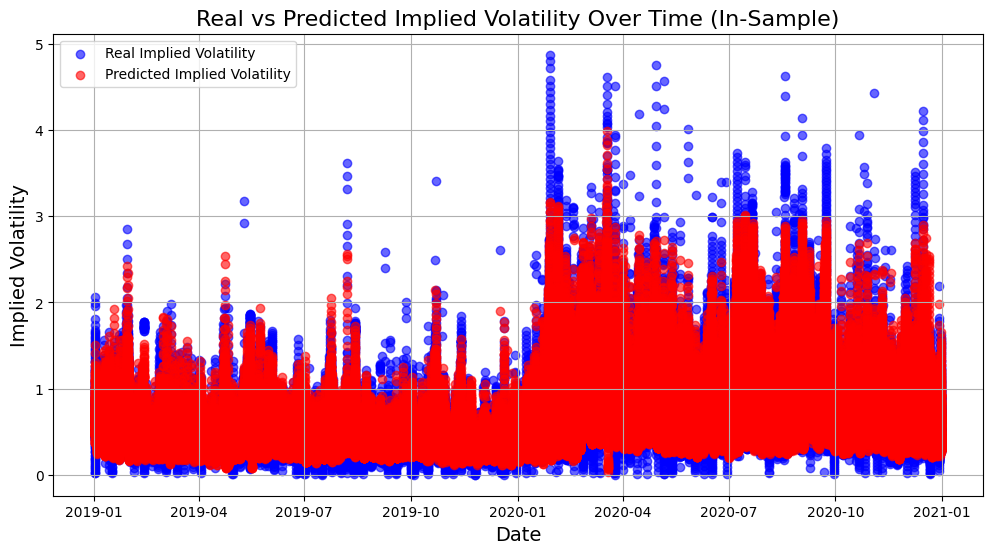

In-sample RMSE: 0.1605
In-sample R²: 0.8591


In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
import random
import matplotlib.pyplot as plt

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Define your neural network model creation function
def create_model(input_dim, neurons=32, layers=1, dropout_rate=0.0):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(input_dim,)))
    
    for layer in range(layers):
        # Halve the neuron count with each layer, starting from the initial `neurons` value
        neurons_in_layer = max(1, neurons // (2 ** layer))
        model.add(tf.keras.layers.Dense(neurons_in_layer, activation='relu'))
        model.add(tf.keras.layers.Dropout(dropout_rate))
    
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=['mse'])
    return model

def train_and_evaluate(IV, data, selected_features, epochs=100, batch_size=32, neurons=64, layers=2, dropout_rate=0.2, verbose=0):
    if verbose >= 1:
        print("Retraining final model on combined 2019 and 2020 data...")

    # Combine training and validation data (2019 and 2020)
    combined_data = data[data['date'].dt.year <= 2020]
    combined_x = combined_data[selected_features]
    combined_y = combined_data[IV]

    input_dim = combined_x.shape[1]

    final_model = create_model(input_dim, neurons=neurons, layers=layers, dropout_rate=dropout_rate)
    final_model.fit(
        combined_x,
        combined_y,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )

    # In-sample predictions and score calculation
    y_pred_in_sample = final_model.predict(combined_x)
    in_sample_rmse = np.sqrt(mean_squared_error(combined_y, y_pred_in_sample))
    in_sample_r2 = r2_score(combined_y, y_pred_in_sample)

    plot_real_vs_predicted(combined_data, combined_y, y_pred_in_sample, 'In-Sample')

    if verbose >= 1:
        print(f"In-sample RMSE: {in_sample_rmse:.4f}")
        print(f"In-sample R²: {in_sample_r2:.4f}")

    return final_model

def plot_real_vs_predicted(test_data, real_values, predicted_values, title):
    """
    Plot Real vs Predicted Implied Volatility over time.

    Parameters:
    test_data (pd.DataFrame): The test dataset containing the date information.
    real_values (np.array or pd.Series): The real implied volatility values.
    predicted_values (np.array or pd.Series): The predicted implied volatility values.
    title (str): The title for the plot.
    """
    plt.figure(figsize=(12, 6))
    
    # Scatter plot for Real Implied Volatility
    plt.scatter(test_data['date'], real_values, label='Real Implied Volatility', color='blue', alpha=0.6)
    
    # Scatter plot for Predicted Implied Volatility
    plt.scatter(test_data['date'], predicted_values, label='Predicted Implied Volatility', color='red', alpha=0.6)
    
    # Labels and title
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Implied Volatility', fontsize=14)
    plt.title(f'Real vs Predicted Implied Volatility Over Time ({title})', fontsize=16)
    
    # Add a legend
    plt.legend()
    
    # Grid for better visualization
    plt.grid(True)
    
    # Display the plot
    plt.show()

# Define your hyperparameters for the model
epochs = 50
batch_size = 32
neurons = 32
layers = 1
dropout_rate = 0.05

# Run the function with your call or put options data
final_model_nn = train_and_evaluate(impl_volatility, data, totalList, epochs, batch_size, neurons, layers, dropout_rate, verbose=1)


In [36]:
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error, r2_score
# import numpy as np
# import pandas as pd
# import joblib
# import tensorflow as tf

# # def create_model(input_dim, neurons=32, layers=1, dropout_rate=0.0):
# #     model = tf.keras.Sequential()
# #     model.add(tf.keras.layers.Input(shape=(input_dim,)))
# #     for _ in range(layers):
# #         model.add(tf.keras.layers.Dense(neurons, activation='relu'))
# #         model.add(tf.keras.layers.Dropout(dropout_rate))
# #     model.add(tf.keras.layers.Dense(1, activation='linear'))
# #     model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
# #                   loss='mean_squared_error',
# #                   metrics=['mse'])
# #     return model

# # Define your neural network model creation function
# def create_model(input_dim, neurons=32, layers=1, dropout_rate=0.0):
#     model = tf.keras.Sequential()
#     model.add(tf.keras.layers.Input(shape=(input_dim,)))
    
#     for layer in range(layers):
#         # Halve the neuron count with each layer, starting from the initial `neurons` value
#         neurons_in_layer = max(1, neurons // (2 ** layer))
#         model.add(tf.keras.layers.Dense(neurons_in_layer, activation='relu'))
#         model.add(tf.keras.layers.Dropout(dropout_rate))
    
#     model.add(tf.keras.layers.Dense(1, activation='linear'))
#     model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
#                   loss='mean_squared_error',
#                   metrics=['mse'])
#     return model


# def train_and_evaluate(IV, data, selected_features, epochs=100, batch_size=32, neurons=64, layers=2, dropout_rate=0.2, verbose=0):

#     if verbose >= 1:
#         print("Retraining final ElasticNet model on combined 2019 and 2020 data...")

#     # Combine training and validation data (2019 and 2020)
#     combined_data = data[data['date'].dt.year <= 2020]
#     combined_x = combined_data[selected_features]
#     combined_y = combined_data[IV]

#     input_dim = combined_x.shape[1]

#     final_model = create_model(input_dim, neurons=neurons, layers=layers, dropout_rate=dropout_rate)
#     final_model.fit(
#         combined_x,
#         combined_y,
#         epochs=epochs,
#         batch_size=batch_size,
#         verbose=1
#     )

#     # In-sample predictions and score calculation
#     y_pred_in_sample = final_model.predict(combined_x)
#     in_sample_rmse = np.sqrt(mean_squared_error(combined_y, y_pred_in_sample))
#     in_sample_r2 = r2_score(combined_y, y_pred_in_sample)

#     plot_real_vs_predicted(combined_data, combined_y, y_pred_in_sample, 'In-Sample')

#     if verbose >= 1:
#         print(f"In-sample RMSE: {in_sample_rmse:.4f}")
#         print(f"In-sample R²: {in_sample_r2:.4f}")

#     # # Extract feature importances
#     # importance = final_model.feature_importances_
#     # importance_df = pd.DataFrame({
#     #     'Feature': selected_features,
#     #     'Importance': importance
#     # }).sort_values(by='Importance', ascending=False)

#     # # Normalize importance so that the sum is 1
#     # importance_df['Importance'] = importance_df['Importance'] / importance_df['Importance'].sum()

#     # # Select the top 10 features
#     # top_10_features_df = importance_df.head(10)

#     # # Plot the normalized importance of the top 10 features
#     # plt.figure(figsize=(10, 8))
#     # plt.barh(top_10_features_df['Feature'], top_10_features_df['Importance'], color='skyblue')
#     # plt.xlabel('Importance')
#     # plt.title('Top 10 Feature Importance from Random Forest Model')
#     # plt.gca().invert_yaxis()  # Invert y-axis for descending order
#     # plt.grid(True, axis='x', linestyle='--', alpha=0.7)
#     # plt.show()

#     # # Save the final model and selected features
#     # joblib.dump(final_model, 'final_random_forest_model.pkl')
#     # joblib.dump(selected_features, 'selected_features.pkl')

#     # print("Final model and selected features have been saved.")
#     # return final_model, selected_features

#     return final_model

# def plot_real_vs_predicted(test_data, real_values, predicted_values, title):
#     """
#     Plot Real vs Predicted Implied Volatility over time.

#     Parameters:
#     test_data (pd.DataFrame): The test dataset containing the date information.
#     real_values (np.array or pd.Series): The real implied volatility values.
#     predicted_values (np.array or pd.Series): The predicted implied volatility values.
#     title (str): The title for the plot.
#     """
#     plt.figure(figsize=(12, 6))
    
#     # Scatter plot for Real Implied Volatility
#     plt.scatter(test_data['date'], real_values, label='Real Implied Volatility', color='blue', alpha=0.6)
    
#     # Scatter plot for Predicted Implied Volatility
#     plt.scatter(test_data['date'], predicted_values, label='Predicted Implied Volatility', color='red', alpha=0.6)
    
#     # Labels and title
#     plt.xlabel('Date', fontsize=14)
#     plt.ylabel('Implied Volatility', fontsize=14)
#     plt.title(f'Real vs Predicted Implied Volatility Over Time ({title})', fontsize=16)
    
#     # Add a legend
#     plt.legend()
    
#     # Grid for better visualization
#     plt.grid(True)
    
#     # Display the plot
#     plt.show()

# # Define your hyperparameters for the model
# epochs = 50
# batch_size = 32
# neurons = 32
# layers = 1
# dropout_rate = 0.2

# # Run the function with your call or put options data
# final_model_nn = train_and_evaluate('impl_volatility', data, totalList, epochs, batch_size, neurons, layers, dropout_rate, verbose=1)


In [10]:
# import pandas as pd
# import numpy as np
# from sklearn.inspection import permutation_importance
# from sklearn.metrics import mean_squared_error
# import matplotlib.pyplot as plt

# # Assuming 'final_model_nn' is your trained Keras model and 'data' is your DataFrame
# combined_x = data[totalList]  # Predictor variables
# combined_y = data["impl_volatility"]  # Target variable

# # Define a custom MSE scoring function
# def mse_scoring(estimator, X, y):
#     y_pred = estimator.predict(X)
#     return mean_squared_error(y, y_pred)

# # Calculate permutation importance with custom MSE scoring
# results = permutation_importance(
#     final_model_nn,
#     combined_x,
#     combined_y,
#     scoring=mse_scoring,
#     n_repeats=1,  # Increased repeats for robustness
#     random_state=42
# )

# # Extract the feature importances and normalize to sum to 1
# importance = results.importances_mean
# importance /= importance.sum()  # Normalize to sum to 1

# # Get predictions and calculate overall MSE
# pred_y = final_model_nn.predict(combined_x)
# mse_score = mean_squared_error(combined_y, pred_y)

# # Create a DataFrame with normalized feature importance scores
# feature_importance_networks = pd.DataFrame({
#     'feature': combined_x.columns,
#     'importance': importance
# })

# # Print the MSE score
# print(f"Mean Squared Error (MSE): {mse_score}")

# # Sort by 'importance' in descending order
# sorted_importance = feature_importance_networks.sort_values(by='importance', ascending=False)

# # Display sorted feature importances
# print(sorted_importance)

In [9]:
# import matplotlib.pyplot as plt

# def plot_feature_importance_barplot(sorted_importance, top_n=10):
#     """
#     Create a horizontal bar plot showing the top N feature importance based on MSE.

#     Parameters:
#     sorted_importance (pd.DataFrame): Sorted feature importance DataFrame, normalized.
#     top_n (int): Number of top features to plot.
#     """
#     # Select the top N features based on importance
#     top_features = sorted_importance.head(top_n)

#     # Sort the top N features by importance for plotting
#     top_features = top_features.sort_values(by='importance', ascending=False)

#     # Plot the normalized importance of the top N features
#     plt.figure(figsize=(10, 8))
#     plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
#     plt.xlabel('Importance')
#     plt.title('Top 10 Feature Importance based on MSE')
#     plt.gca().invert_yaxis()  # Invert y-axis for descending order
#     plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    
#     plt.show()

# # Example usage: Plot the top 10 features
# plot_feature_importance_barplot(sorted_importance, top_n=10)


In [10]:
sorted_importance["importance"].tolist()

[0.42853769820138093,
 0.35267490531791984,
 0.14261251024427102,
 0.042597165182033735,
 0.0335777210543944]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
AAPL Average RMSE (over 1 runs): 0.10468961724870322
AAPL Average R² (over 1 runs): 0.6263023091875253


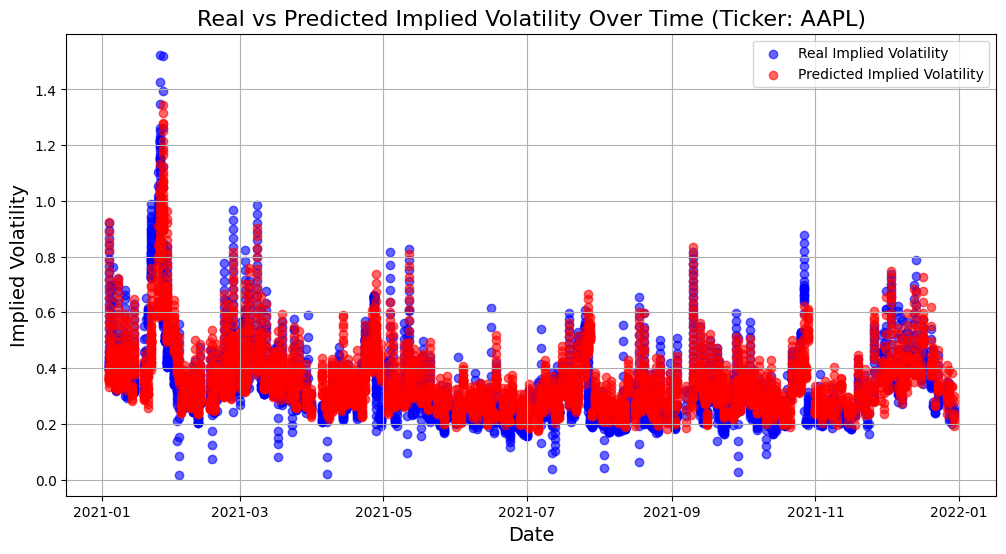

1545/1545 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
AMZN Average RMSE (over 1 runs): 0.10780330253201657
AMZN Average R² (over 1 runs): 0.8167641453530561


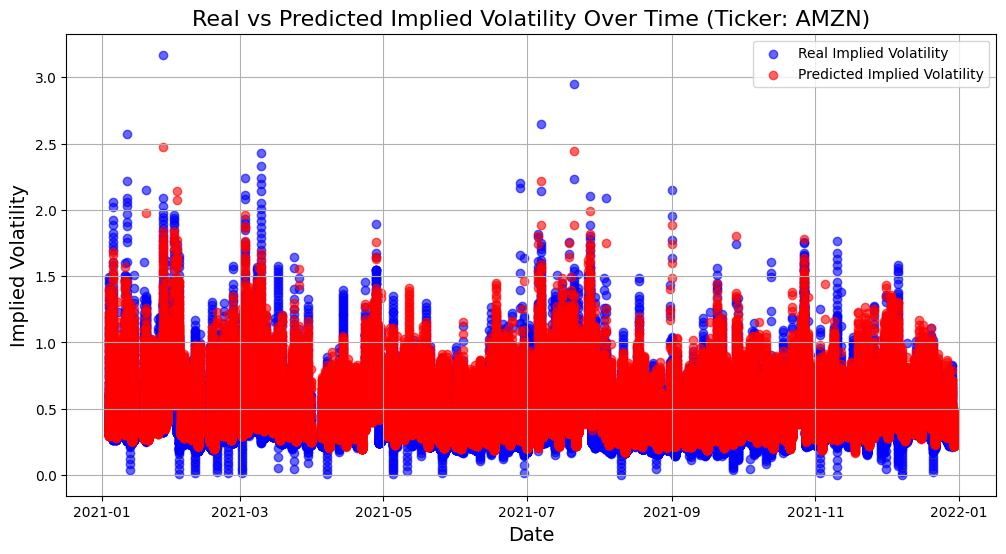

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
META Average RMSE (over 1 runs): 0.11645956487806597
META Average R² (over 1 runs): 0.6647746035549305


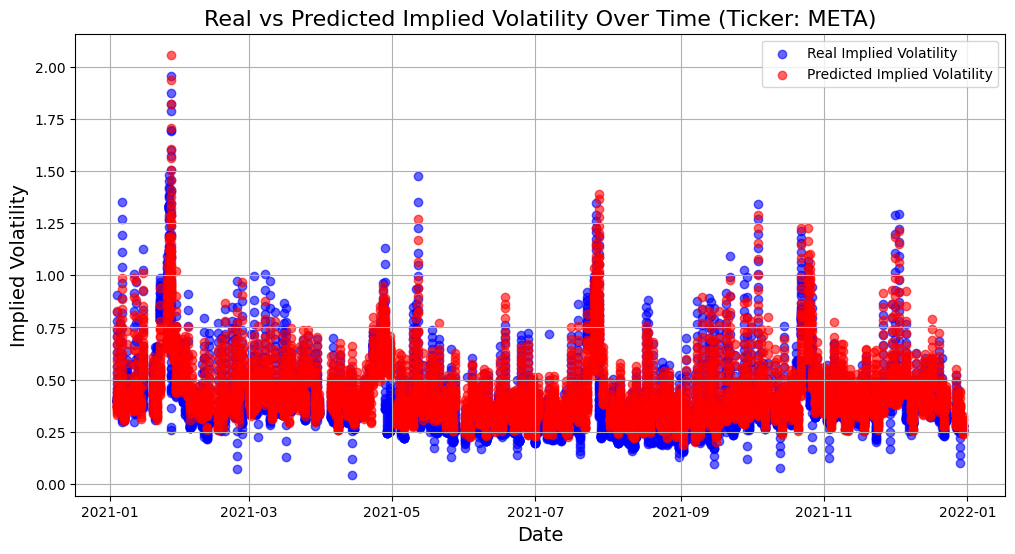

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
MSFT Average RMSE (over 1 runs): 0.09546716869238898
MSFT Average R² (over 1 runs): 0.5344899099626842


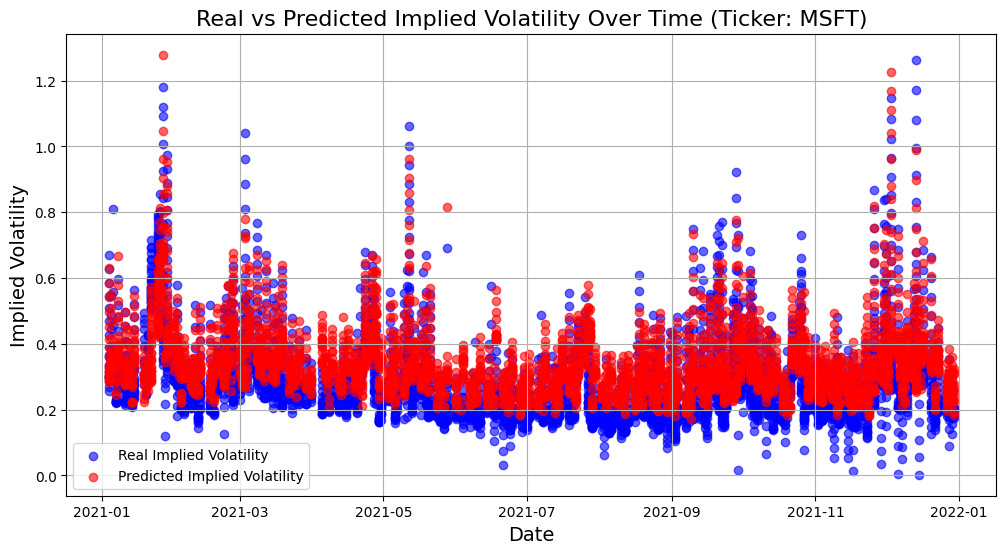

398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step
NVDA Average RMSE (over 1 runs): 0.1678015369696923
NVDA Average R² (over 1 runs): 0.7166924746390855


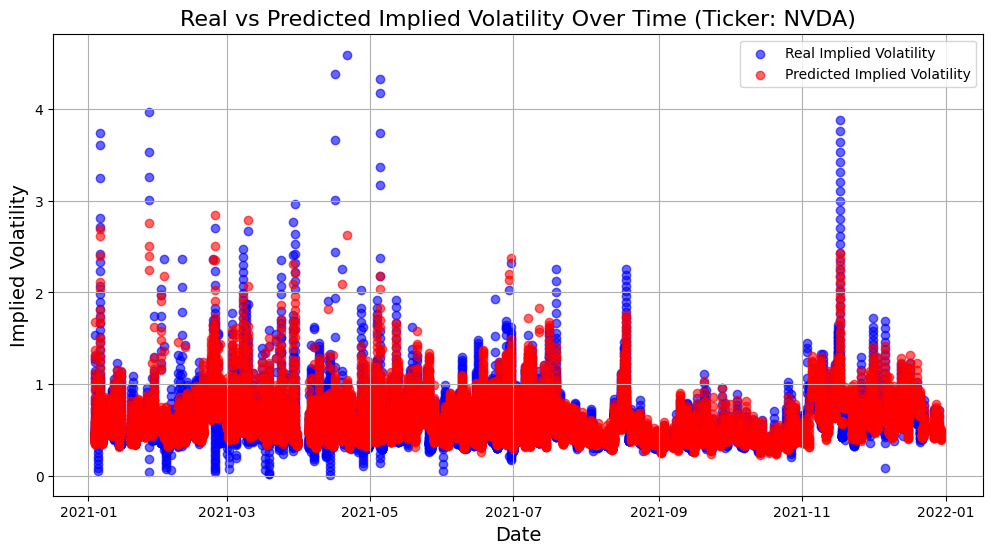

717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
TSLA Average RMSE (over 1 runs): 0.18512780213109567
TSLA Average R² (over 1 runs): 0.8195402156853056


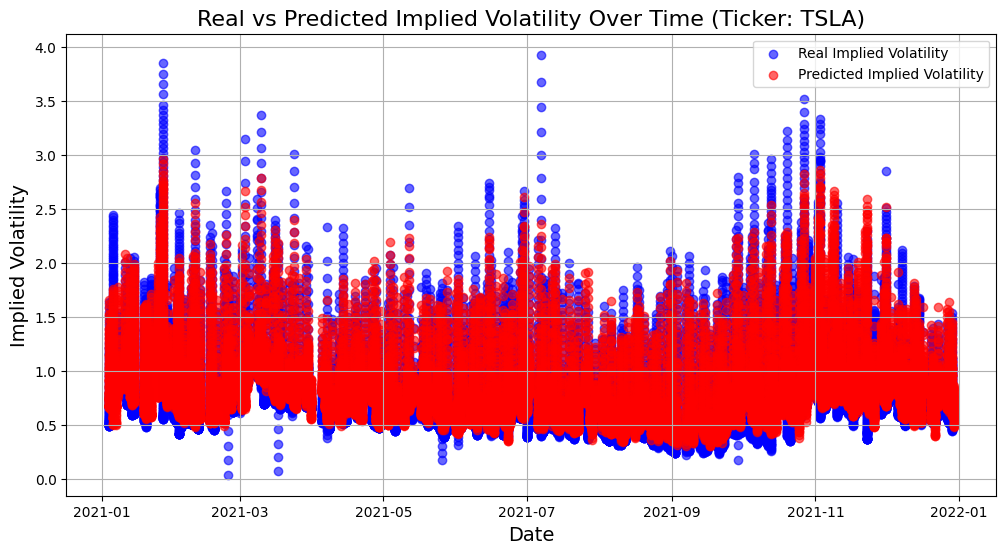

100427
100427
[ 0.08584101  0.08243564  0.0819997  ...  0.006605   -0.01776048
 -0.00579493]
Daily average errors calculated for 250 days.
Newey-West Standard Error (Based on Daily Averages): 0.004616593438932958
Daily average errors and Newey-West statistics saved to /Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/Notebook_modeling/db_performance_evaluation/nn.csv
Overall Weighted RMSE: 0.1374437486625748
Overall Weighted R²: 0.7745017733748543
Overall Combined RMSE: 0.1374437486625748
Overall Combined R²: 0.8507643507994849
Overall Weighted RMSE: 0.1374437486625748
Overall Weighted R²: 0.7745017733748543
Ticker-Specific Results:
{'Ticker': 'AAPL', 'Average RMSE': 0.10468961724870322, 'Average R²': 0.6263023091875253}
{'Ticker': 'AMZN', 'Average RMSE': 0.10780330253201657, 'Average R²': 0.8167641453530561}
{'Ticker': 'META', 'Average RMSE': 0.11645956487806597, 'Average R²': 0.6647746035549305}
{'Ticker': 'MSFT', 'Average RMSE': 0.09546716869238898, 'Average R²': 0.5344

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def newey_west_standard_error(errors, lag=1):
    """
    Computes the Newey-West standard error for the series of prediction errors.
    
    Parameters:
    - errors: Array-like of prediction errors
    - lag: Maximum lag to use for the Newey-West estimator (default is 1)
    
    Returns:
    - Newey-West standard error of the prediction errors
    """
    X = np.ones(len(errors))  # Constant term for OLS
    ols_model = sm.OLS(errors, X).fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    return ols_model.bse[0]  # Standard error of the constant term

def predict_test_data_per_ticker(IV, test_data, model, selected_features, n_runs=1):
    """
    Predict the target variable for the test set using the trained NN model,
    calculate RMSE and R² for each ticker, and compute weighted overall metrics.

    Parameters:
    IV (str): The name of the independent variable to predict.
    test_data (pd.DataFrame): The test dataset.
    model: The trained neural network model.
    selected_features (list): The list of features used for modeling.
    n_runs (int): Number of times to repeat predictions for averaging.

    Returns:
    dict: Contains RMSE and R² values for each ticker and overall weighted metrics.
    """
    results_list_all = []  # Initialize list to store results
    unique_tickers = test_data['Ticker'].unique()

    # Initialize accumulators for overall RMSE and R²
    total_rmse_weighted_sum = 0
    total_r2_weighted_sum = 0
    total_observations = 0

        # Collect all actual and predicted values for combined metrics
    combined_actual = []
    combined_predicted = []

    for ticker in unique_tickers:
        # Filter the data for the current ticker
        data_ticker = test_data[test_data['Ticker'] == ticker]

        # Separate features and target for the ticker
        y_ticker_actual = data_ticker[IV]
        X_ticker = data_ticker[selected_features]

        rmse_scores = []
        r2_scores = []

        # Run predictions n_runs times
        for _ in range(n_runs):
            y_ticker_pred = model.predict(X_ticker)

            # Collect predictions and actual values for overall calculation
            combined_actual.extend(y_ticker_actual)
            combined_predicted.extend(y_ticker_pred)

            # Calculate RMSE and R² for the ticker-specific implied volatility prediction
            rmse_ticker = np.sqrt(mean_squared_error(y_ticker_actual, y_ticker_pred))
            r2_ticker = r2_score(y_ticker_actual, y_ticker_pred)

            rmse_scores.append(rmse_ticker)
            r2_scores.append(r2_ticker)

            if np.any(np.isnan(y_ticker_actual)) or np.any(np.isnan(y_ticker_pred)):
                print(f"NaN values found for ticker. Skipping.")
                continue
            if np.any(np.isinf(y_ticker_actual)) or np.any(np.isinf(y_ticker_pred)):
                print(f"Inf values found for ticker. Skipping.")
                continue

        # Calculate average RMSE and R² over n_runs
        avg_rmse = np.mean(rmse_scores)
        avg_r2 = np.mean(r2_scores)

        # Calculate the number of observations for the ticker
        num_observations = len(y_ticker_actual)

        # Weighted summing for overall RMSE and R²
        total_rmse_weighted_sum += num_observations * avg_rmse**2
        total_r2_weighted_sum += num_observations * avg_r2
        total_observations += num_observations

        # Save ticker-specific results
        results_list_all.append({
            'Ticker': ticker,
            'Average RMSE': avg_rmse,
            'Average R²': avg_r2
        })
        print(f'{ticker} Average RMSE (over {n_runs} runs): {avg_rmse}')
        print(f'{ticker} Average R² (over {n_runs} runs): {avg_r2}')

        # Plot Real vs Predicted values (last run)
        plot_real_vs_predicted(data_ticker, y_ticker_actual, y_ticker_pred, f'Ticker: {ticker}')

    # Calculate overall metrics based on combined data (not weighted)
    combined_actual = np.array(combined_actual)
    combined_predicted = np.array(combined_predicted)
    combined_predicted = combined_predicted.flatten()
    print(len(combined_actual))
    print(len(combined_predicted))


    # Example calculation
    errors_test = combined_actual - combined_predicted
    print(errors_test)
    test_data['Errors'] = errors_test  # Add errors to the test dataset

    # Group errors by date and calculate daily averages
    if 'date' in test_data.columns:
        daily_avg_errors = test_data.groupby('date')['Errors'].mean()
        print(f"Daily average errors calculated for {len(daily_avg_errors)} days.")
    else:
        raise ValueError("The dataset does not contain a 'date' column.")

    # Calculate Newey-West standard error using daily averages
    nw_std_error_test = newey_west_standard_error(daily_avg_errors.values, lag=1)
    print(f"Newey-West Standard Error (Based on Daily Averages): {nw_std_error_test}")

    # Save the daily errors and Newey-West standard error into a CSV
    file_path = '/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/Notebook_modeling/db_performance_evaluation/nn.csv'

    # Create a DataFrame with daily averaged errors and repeated Newey-West standard error
    dm_test_data = pd.DataFrame({
        'Date': daily_avg_errors.index,
        'Daily Avg Errors': daily_avg_errors.values,
        'Newey-West Std Error': [nw_std_error_test] * len(daily_avg_errors)
    })

    # Save the DataFrame to a CSV
    dm_test_data.to_csv(file_path, index=False)
    print(f"Daily average errors and Newey-West statistics saved to {file_path}")
    overall_combined_rmse = np.sqrt(mean_squared_error(combined_actual, combined_predicted))
    overall_combined_r2 = r2_score(combined_actual, combined_predicted)

    # Calculate weighted metrics
    overall_rmse = np.sqrt(total_rmse_weighted_sum / total_observations)
    overall_r2 = total_r2_weighted_sum / total_observations

    print(f'Overall Weighted RMSE: {overall_rmse}')
    print(f'Overall Weighted R²: {overall_r2}')
    print(f'Overall Combined RMSE: {overall_combined_rmse}')
    print(f'Overall Combined R²: {overall_combined_r2}')

    return combined_actual, combined_predicted, {
        'Ticker_Results': results_list_all,
        'Overall_RMSE': overall_rmse,
        'Overall_R²': overall_r2,
        'Overall_Combined_RMSE': overall_combined_rmse,
        'Overall_Combined_R²': overall_combined_r2
    }


def plot_real_vs_predicted(test_data, real_values, predicted_values, title):
    """
    Plot Real vs Predicted Implied Volatility over time.

    Parameters:
    test_data (pd.DataFrame): The test dataset containing the date information.
    real_values (np.array or pd.Series): The real implied volatility values.
    predicted_values (np.array or pd.Series): The predicted implied volatility values.
    title (str): The title for the plot.
    """
    plt.figure(figsize=(12, 6))
    plt.scatter(test_data['date'], real_values, label='Real Implied Volatility', color='blue', alpha=0.6)
    plt.scatter(test_data['date'], predicted_values, label='Predicted Implied Volatility', color='red', alpha=0.6)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Implied Volatility', fontsize=14)
    plt.title(f'Real vs Predicted Implied Volatility Over Time ({title})', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
# Assuming `datat` (test data), `final_model_nn` (trained neural network), and `totalList` (features) are defined
actual_data, predicted_data, results = predict_test_data_per_ticker(impl_volatility, datat, final_model_nn, totalList, n_runs=1)

# Print overall weighted metrics
print(f"Overall Weighted RMSE: {results['Overall_RMSE']}")
print(f"Overall Weighted R²: {results['Overall_R²']}")

# Print ticker-specific results
print("Ticker-Specific Results:")
for ticker_result in results['Ticker_Results']:
    print(ticker_result)


3139/3139 ━━━━━━━━━━━━━━━━━━━━ 1s 246us/step
Baseline R² (OOS): 0.7119
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 1s 210us/step
Feature: T, Baseline R²: 0.7119, Perturbed R²: 0.6945, Drop: 0.0174
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 1s 207us/step
Feature: moneyness, Baseline R²: 0.7119, Perturbed R²: 0.2590, Drop: 0.4529
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 1s 204us/step
Feature: previous_iv, Baseline R²: 0.7119, Perturbed R²: 0.4614, Drop: 0.2505
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 1s 242us/step
Feature: spread_option, Baseline R²: 0.7119, Perturbed R²: 0.6901, Drop: 0.0218
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 1s 241us/step
Feature: 2Y_bond, Baseline R²: 0.7119, Perturbed R²: 0.7046, Drop: 0.0073
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 1s 203us/step
Feature: RET, Baseline R²: 0.7119, Perturbed R²: 0.7136, Drop: 0.0000
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 1s 215us/step
Feature: cp_flag, Baseline R²: 0.7119, Perturbed R²: 0.6361, Drop: 0.0758
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 1s 236us/step
Feature: ticker_TSLA, Baseline R²: 0.7119, Pertur

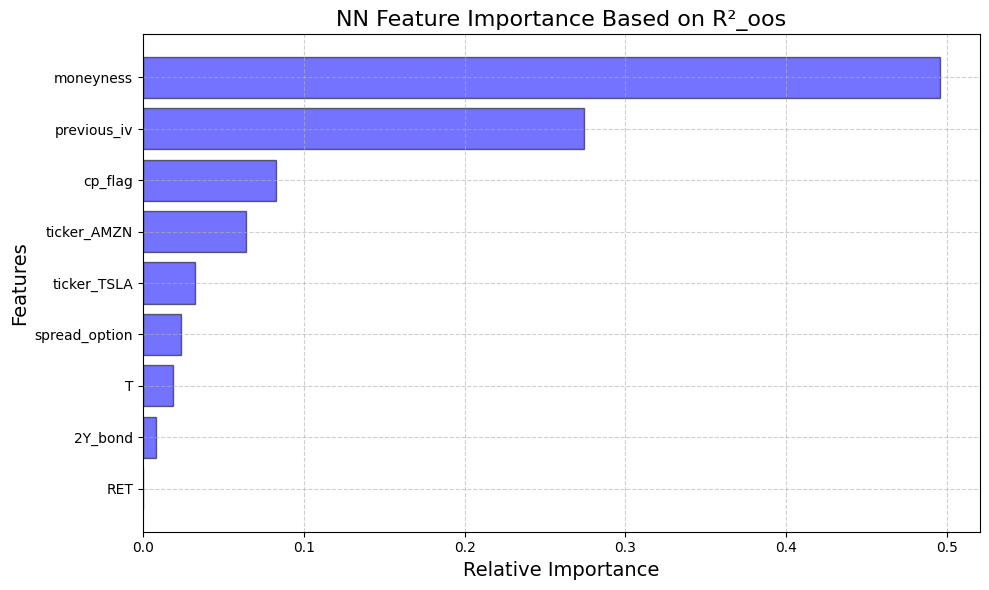

In [28]:
def calculate_feature_importance_r2_nn(data_test, features, target, model):
    """
    Calculate feature importance for NN based on the relative drop in R²_oos when a feature is set to zero.

    Parameters:
    - data_test: Test dataset
    - features: List of feature names
    - target: Target variable (e.g., implied volatility)
    - model: Trained neural network model
    
    Returns:
    - importance_df: DataFrame with feature importance values.
    - baseline_r2: Baseline R²_oos value.
    """
    # Prepare the test dataset
    X_test = data_test[features].values
    y_test = data_test[target].values

    # Predict on the test data and calculate baseline R²_oos
    y_test_pred = model.predict(X_test).flatten()
    baseline_r2 = r2_score(y_test, y_test_pred)
    print(f"Baseline R² (OOS): {baseline_r2:.4f}")

    # Calculate the drop in R²_oos for each feature
    r2_drops = []
    for i, feature in enumerate(features):
        # Perturb the test data by setting the feature column to zero
        X_test_zeroed = X_test.copy()
        X_test_zeroed[:, i] = 0

        # Predict and calculate R²_oos
        y_test_pred_zeroed = model.predict(X_test_zeroed).flatten()
        r2_zeroed = r2_score(y_test, y_test_pred_zeroed)
        r2_drop = max(0, baseline_r2 - r2_zeroed)  # Ensure the drop is non-negative
        r2_drops.append(r2_drop)

        print(f"Feature: {feature}, Baseline R²: {baseline_r2:.4f}, Perturbed R²: {r2_zeroed:.4f}, Drop: {r2_drop:.4f}")

    # Normalize the importance scores
    r2_importance = np.array(r2_drops)
    if r2_importance.sum() > 0:
        r2_importance = r2_importance / r2_importance.sum()  # Normalize to sum to 1
    else:
        r2_importance = np.zeros_like(r2_importance)  # Handle edge case where all drops are zero

    # Create a DataFrame for feature importance
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': r2_importance
    }).sort_values(by='Importance', ascending=False)

    return importance_df, baseline_r2


def plot_feature_importance(importance_df, title="Feature Importance"):
    """
    Plot feature importance as a bar chart.
    
    Parameters:
    - importance_df: DataFrame containing feature names and importance scores.
    - title: Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='blue', edgecolor='black', alpha=0.55)
    plt.xlabel('Relative Importance', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.title(title, fontsize=16)
    plt.gca().invert_yaxis()  # Invert y-axis for descending order
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Calculate feature importance for NN
feature_importance_nn, baseline_r2_nn = calculate_feature_importance_r2_nn(
    data_test=datat,
    features=totalList,
    target='impl_volatility',
    model=final_model_nn  # Trained NN model
)

# Print and visualize the feature importance
print("Feature Importance (R²_oos drop) for Neural Network:")
print(feature_importance_nn)

plot_feature_importance(feature_importance_nn, title="NN Feature Importance Based on R²_oos")


In [30]:
# feature_importance_nn["Importance"].tolist()
feature_importance_nn["Feature"].tolist()

['moneyness',
 'previous_iv',
 'cp_flag',
 'ticker_AMZN',
 'ticker_TSLA',
 'spread_option',
 'T',
 '2Y_bond',
 'RET']

In [14]:
# Flatten predicted_data if it's 2D
predicted_data_flattened = predicted_data.flatten()

# Ensure the shapes match
if predicted_data_flattened.shape == actual_data.shape:
    difference = actual_data - predicted_data_flattened
else:
    print("Shapes do not match. Check the dimensions of the arrays.")

# Output the difference
print(difference)

[ 0.07313926  0.04226846  0.08486538 ... -0.14026352 -0.13416991
 -0.13444146]


In [17]:
datat

,date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,...,total_iv_weighted,previous_iv,previous_iv_all,ticker_AAPL,ticker_AMZN,ticker_META,ticker_MSFT,ticker_NVDA,ticker_TSLA,Ticker
0,2021-01-04,0,-1.259461,-0.464302,-0.473113,-0.119704,-0.033247,0.622737,-0.216815,0.190278,...,-0.169351,-0.501600,-0.211828,1,0,0,0,0,0,AAPL
1,2021-01-04,0,-1.254711,-0.450505,-0.459201,0.462214,0.205921,0.508636,-0.460255,0.983377,...,-0.140783,-0.501600,-0.211828,1,0,0,0,0,0,AAPL
2,2021-01-04,1,-1.249011,-0.366858,-0.377419,3.693194,0.792270,0.433412,1.441396,2.296520,...,0.433592,-0.501600,-0.211828,1,0,0,0,0,0,AAPL
3,2021-01-04,1,-1.248061,-0.388848,-0.398919,10.713529,5.918095,0.428775,1.255893,2.330219,...,1.145629,-0.501600,-0.211828,1,0,0,0,0,0,AAPL
4,2021-01-04,1,-1.247111,-0.407388,-0.417046,3.797118,0.744735,0.426358,1.072019,2.266863,...,0.212903,-0.501600,-0.211828,1,0,0,0,0,0,AAPL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106281,2021-12-30,1,-0.245812,-0.469476,-0.477328,-0.077215,0.019763,0.840809,0.013198,-0.467738,...,-0.169389,0.198613,-0.314645,0,0,0,0,0,1,TSLA
106282,2021-12-30,1,-0.250562,-0.468614,-0.476485,0.441831,0.662109,0.822016,0.016923,-0.464397,...,-0.157560,0.198613,-0.314645,0,0,0,0,0,1,TSLA
106283,2021-12-30,0,-0.359812,-0.148688,-0.148092,1.159970,-0.034989,0.460012,-1.137629,0.129974,...,0.558154,0.198613,-0.314645,0,0,0,0,0,1,TSLA
106284,2021-12-30,1,-0.364562,0.198402,0.208125,1.402556,-0.057886,0.451085,1.786211,0.102050,...,1.543815,0.198613,-0.314645,0,0,0,0,0,1,TSLA


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def predict_test_data_per_ticker(IV, train_data, test_data, model, selected_features, n_runs=10):
    """
    Predict the target variable for the test set using the trained model and scale data with MinMaxScaler.
    
    Parameters:
    IV (str): The name of the independent variable to predict.
    train_data (pd.DataFrame): The training dataset used for fitting the scaler.
    test_data (pd.DataFrame): The test dataset.
    model: The trained ElasticNet model.
    selected_features (list): The list of features selected by ElasticNet during training.
    n_runs (int): Number of times to repeat predictions for averaging.

    Returns:
    list: Averaged RMSE and R² values for each ticker in the test set.
    """
    results_list_all = []  # Initialize list to store results
    unique_tickers = test_data['Ticker'].unique()
    
    for ticker in unique_tickers:
        # Filter the data for the current ticker
        data_ticker = test_data[test_data['Ticker'] == ticker]
        
        # Separate features and target for the ticker
        y_ticker_actual = data_ticker[IV]
        X_ticker = data_ticker[selected_features]
        
        rmse_scores = []
        r2_scores = []

        # Run predictions n_runs times
        for _ in range(n_runs):
            y_ticker_pred = model.predict(X_ticker)

            # Calculate RMSE and R² for the ticker-specific implied volatility prediction
            rmse_ticker = np.sqrt(mean_squared_error(y_ticker_actual, y_ticker_pred))
            r2_ticker = r2_score(y_ticker_actual, y_ticker_pred)

            rmse_scores.append(rmse_ticker)
            r2_scores.append(r2_ticker)

        # Calculate average RMSE and R² over n_runs
        avg_rmse = np.mean(rmse_scores)
        avg_r2 = np.mean(r2_scores)
        
        # Save averaged results in the list
        results_list_all.append({
            'Ticker': ticker,
            'RMSE': avg_rmse,
            'R²': avg_r2
        })
        print(f'{ticker} Average RMSE (over {n_runs} runs): {avg_rmse}')
        print(f'{ticker} Average R² (over {n_runs} runs): {avg_r2}')

        # Plot Real vs Predicted values (last run)
        plot_real_vs_predicted(data_ticker, y_ticker_actual, y_ticker_pred, f'Ticker: {ticker}')

    return results_list_all

def plot_real_vs_predicted(test_data, real_values, predicted_values, title):
    """
    Plot Real vs Predicted Implied Volatility over time.

    Parameters:
    test_data (pd.DataFrame): The test dataset containing the date information.
    real_values (np.array or pd.Series): The real implied volatility values.
    predicted_values (np.array or pd.Series): The predicted implied volatility values.
    title (str): The title for the plot.
    """
    plt.figure(figsize=(12, 6))
    
    # Scatter plot for Real Implied Volatility
    plt.scatter(test_data['date'], real_values, label='Real Implied Volatility', color='blue', alpha=0.6)
    
    # Scatter plot for Predicted Implied Volatility
    plt.scatter(test_data['date'], predicted_values, label='Predicted Implied Volatility', color='red', alpha=0.6)
    
    # Labels and title
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Implied Volatility', fontsize=14)
    plt.title(f'Real vs Predicted Implied Volatility Over Time ({title})', fontsize=16)
    
    # Add a legend
    plt.legend()
    
    # Grid for better visualization
    plt.grid(True)
    
    # Display the plot
    plt.show()

# Assuming `data_test_all`, `data_train_tot`, and `selected_features_final` are already defined
results_list_all = predict_test_data_per_ticker(
    'impl_volatility', data, datat_nor, final_model_nn, totalList, n_runs=10
)


NameError: name 'final_rf_model' is not defined

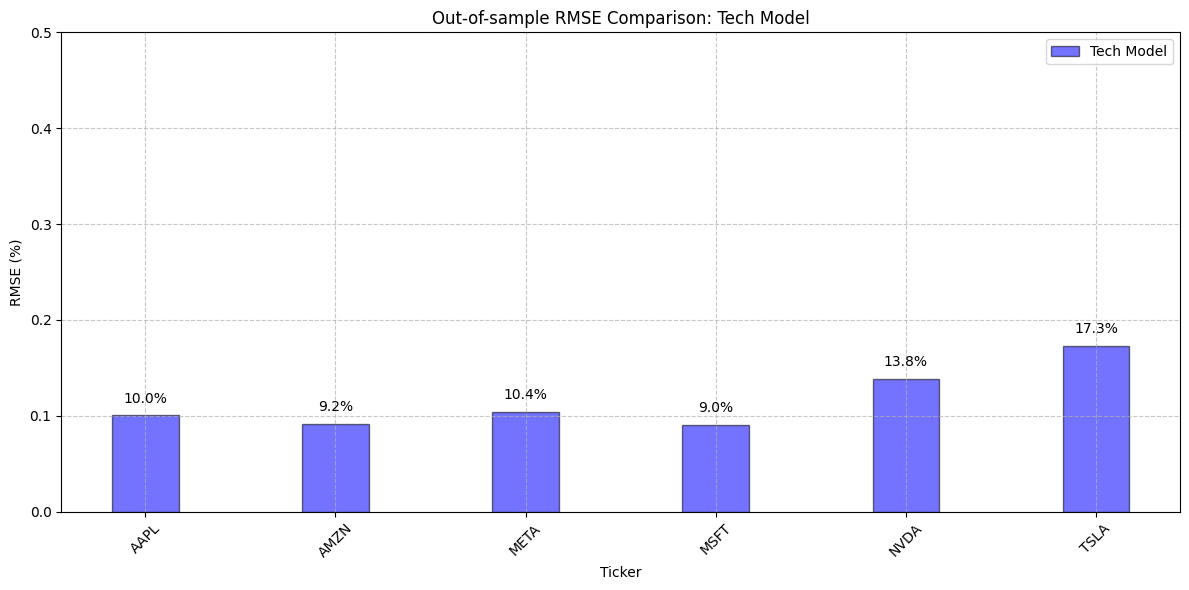

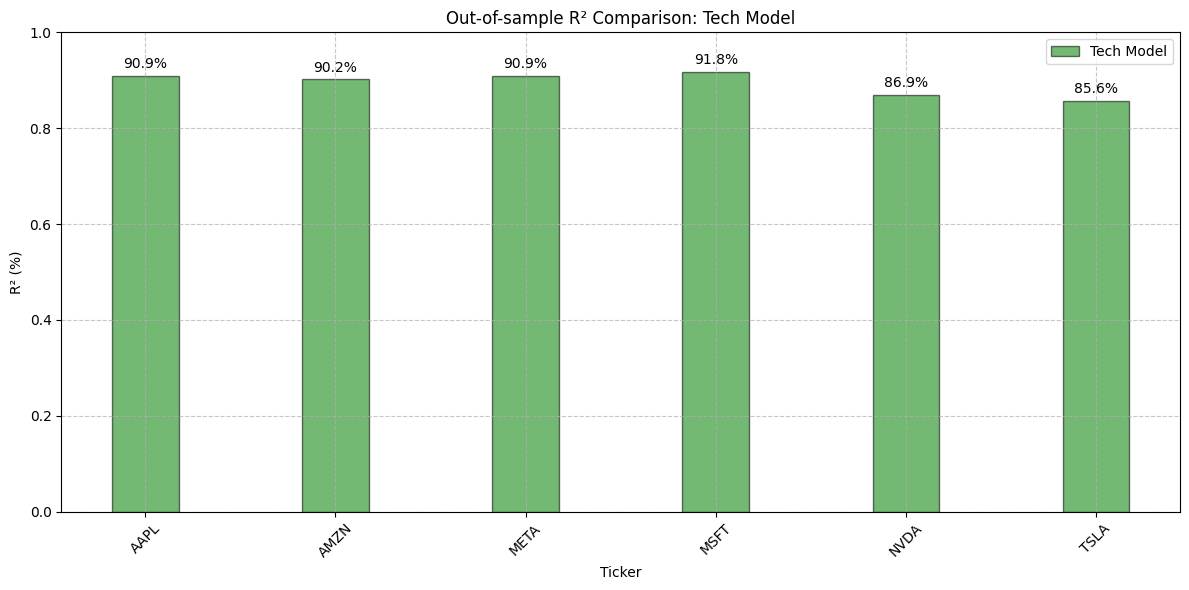

In [27]:
# Convert lists to DataFrames for easier plotting
results_list_all_df = pd.DataFrame(results_list_all).set_index('Ticker').sort_index()

# Define the x locations for the groups and bar width
x = np.arange(len(results_list_all_df.index))
width = 0.35  # Width of the bars

# Plot RMSE comparison
plt.figure(figsize=(12, 6))
bars_all_rmse = plt.bar(x, results_list_all_df['RMSE'], width=width, label='Tech Model', color='blue', alpha=0.55, edgecolor='black')

# Add percentage labels above bars for RMSE (converted to percentage format)
for bar in bars_all_rmse:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height() * 100:.1f}%', ha='center', va='bottom')

plt.xlabel('Ticker')
plt.ylabel('RMSE (%)')
plt.title('Out-of-sample RMSE Comparison: Tech Model')
plt.xticks(ticks=x, labels=results_list_all_df.index, rotation=45)
plt.legend()
plt.ylim([0, 0.5])  # Adjusted for percentage scale
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot R² comparison
plt.figure(figsize=(12, 6))
bars_all_r2 = plt.bar(x, results_list_all_df['R²'], width=width, label='Tech Model', color='green', alpha=0.55, edgecolor='black')

# Add percentage labels above bars for R² (converted to percentage format)
for bar in bars_all_r2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height() * 100:.1f}%', ha='center', va='bottom')

plt.xlabel('Ticker')
plt.ylabel('R² (%)')
plt.title('Out-of-sample R² Comparison: Tech Model')
plt.xticks(ticks=x, labels=results_list_all_df.index, rotation=45)
plt.legend()
plt.ylim([0, 1])  # Adjusted for percentage scale
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [228]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from keras import regularizers
from keras.layers import Dense, Dropout, Input
from keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scikeras.wrappers import KerasRegressor
from keras.optimizers import RMSprop
import tensorflow as tf
import random

# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

# Set the seed before training
set_seed(42)

# Function to calculate Newey-West standard error
def newey_west_standard_error(errors, lag=1):
    """
    Computes the Newey-West standard error for the series of prediction errors.
    
    Parameters:
    - errors: Array-like of prediction errors
    - lag: Maximum lag to use for the Newey-West estimator (default is 1)
    
    Returns:
    - Newey-West standard error of the prediction errors
    """
    X = np.ones(len(errors))  # Constant term for OLS
    ols_model = sm.OLS(errors, X).fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    nw_std_error = ols_model.bse[0]  # Newey-West standard error
    return nw_std_error

# Define the model function with variable neurons, layers, and dropout rate
def create_model(input_dim, neurons=32, layers=1, dropout_rate=0.0):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))  # Input layer

    # First hidden layer
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))  # Dropout after the first hidden layer

    # Additional hidden layers
    for _ in range(layers - 1):
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation='linear'))  # Regression output layer

    # Compile the model
    model.compile(optimizer=RMSprop(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=['mse'])
    return model

# Wrapping the model in KerasRegressor
def create_keras_regressor(input_dim):
    return KerasRegressor(model=create_model, input_dim=input_dim, verbose=1)

# Function to train the model and calculate Newey-West errors
def train_and_evaluate(train_x, train_y, combined_x, combined_y, test_x, test_y, model_name):
    # Get input dimension from the training data
    input_dim = combined_x.shape[1]
    
    # Create KerasRegressor
    model = create_keras_regressor(input_dim)

    # Initialize GridSearchCV with the model and parameter grid
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               scoring='neg_mean_squared_error',  # Scoring based on MSE
                               verbose=3,
                               cv=3, 
                               n_jobs=-1)

    # Perform hyperparameter tuning
    print(f"Running hyperparameter tuning for {model_name}...")
    grid_search.fit(combined_x, combined_y, verbose=1)

    # Get the best estimator and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print(f"Best Parameters for {model_name}: {best_params}")

    # Predict on the test set
    predictions_test = best_model.predict(test_x)

    # Calculate test errors and Newey-West standard error
    errors_test = test_y - predictions_test
    nw_std_error = newey_west_standard_error(errors_test, lag=1)

    print(f"{model_name} Newey-West Standard Error: {nw_std_error:.4f}")

    return errors_test, nw_std_error

# Define the parameter grid for hyperparameter tuning
param_grid = {'batch_size': [32], 'epochs': [50], 'model__dropout_rate': [0.5], 'model__layers': [1], 'model__neurons': [16]}

# Call the function for Call options data
print("\nEvaluating Call options...")
calls_errors, calls_nw_std_error = train_and_evaluate(train_x_c, train_y_c, combined_x_c, combined_y_c, test_x_c, test_y_c, "Call Model")

# Call the function for Put options data
print("\nEvaluating Put options...")
puts_errors, puts_nw_std_error = train_and_evaluate(train_x_p, train_y_p, combined_x_p, combined_y_p, test_x_p, test_y_p, "Put Model")

# Pad the shorter error list with zeros to ensure both lists have the same length
max_length = max(len(puts_errors), len(calls_errors))

puts_errors_padded = np.pad(puts_errors, (0, max_length - len(puts_errors)), 'constant', constant_values=0)
calls_errors_padded = np.pad(calls_errors, (0, max_length - len(calls_errors)), 'constant', constant_values=0)

# Save the results to a DataFrame and CSV
dm_test_data = pd.DataFrame({
    'Put Errors': puts_errors_padded,
    'Call Errors': calls_errors_padded,
    'Put Newey-West Std Error': [puts_nw_std_error] * max_length,  # Constant value for all rows
    'Call Newey-West Std Error': [calls_nw_std_error] * max_length  # Constant value for all rows
})

# Specify the file path for the CSV
file_path = '/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/performence_evaluation/dm_test_errors_nn.csv'

# Save the DataFrame to the specified path
dm_test_data.to_csv(file_path, index=False)

print(f"Test errors and Newey-West statistics saved to {file_path}")



Evaluating Call options...
Running hyperparameter tuning for Call Model...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Epoch 1/50
Epoch 1/50
Epoch 1/50
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 1s 374us/step - loss: 0.6407 - mse: 0.6407 
Epoch 2/50
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 1s 375us/step - loss: 1.6090 - mse: 1.6090
Epoch 2/50
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 1s 378us/step - loss: 0.9213 - mse: 0.9213
Epoch 2/50
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 1s 370us/step - loss: 0.0611 - mse: 0.0611
Epoch 3/50
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 1s 366us/step - loss: 0.1225 - mse: 0.1225
Epoch 3/50
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 1s 374us/step - loss: 0.0720 - mse: 0.0720
Epoch 3/50
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step - loss: 0.0556 - mse: 0.0556
Epoch 4/50
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step - loss: 0.0613 - mse: 0.0613
Epoch 4/50
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 1s 779us/step - loss: 0.0597 - mse: 0.0597
Epoch 4/50
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 1s 385us/step - loss: 0.0509 - mse:

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_18772/1964460253.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nw_std_error = ols_model.bse[0]  # Newey-West standard error


Call Model Newey-West Standard Error: 0.0010

Evaluating Put options...
Running hyperparameter tuning for Put Model...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Epoch 1/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 334us/step - loss: 0.6656 - mse: 0.6656
Epoch 2/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 321us/step - loss: 0.0620 - mse: 0.0620
Epoch 3/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 577us/step - loss: 0.0570 - mse: 0.0570
Epoch 4/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 414us/step - loss: 0.0554 - mse: 0.0554
Epoch 5/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 329us/step - loss: 0.0573 - mse: 0.0573
Epoch 6/50
 336/1521 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step - loss: 0.0541 - mse: 0.0541Epoch 1/50
Epoch 1/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 428us/step - loss: 0.0535 - mse: 0.0535  
Epoch 7/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - loss: 0.8271 - mse: 0.8271
Epoch 2/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step - loss: 1.4350 - mse: 1.4350
Epoch 2/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_18772/1964460253.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nw_std_error = ols_model.bse[0]  # Newey-West standard error


Test errors and Newey-West statistics saved to /Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/performence_evaluation/dm_test_errors_nn.csv


In [219]:


import pandas as pd

# Get predictions
pred_y = best_model_call.predict(combined_x_c)

# Calculate mean squared error
mse_score = mean_squared_error(combined_y_c, pred_y)

# Assuming 'importance' is a list or array of feature importances
# Create a DataFrame with feature importance scores
feature_importance_networks = pd.DataFrame({
    'feature': combined_x_c.columns,  # Assuming feature names come from 'combined_x_p'
    'importance': importance  # Assuming 'importance' is a list or array of the same length as the number of features
})

# Print the MSE score (separately from the feature importances)
print(f"Mean Squared Error (MSE): {mse_score}")

# Sort by 'importance' in descending order
sorted_importance_c = feature_importance_networks.sort_values(by='importance', ascending=False)

# Display sorted feature importances
(sorted_importance_c)



2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 240us/step
Mean Squared Error (MSE): 0.028032797160525903


,feature,importance
3,prev_day_iv,0.756283
17,2Y_bond,0.191636
18,CLOSE_vix,0.170249
16,1Y_bond,0.164074
0,T,0.091177
2,prev2_day_iv,0.064454
21,LOW_vix,0.053092
10,cumulative_return,0.037955
15,10Y_RIR,0.035771
7,ASK,0.032649


<Figure size 1000x600 with 0 Axes>

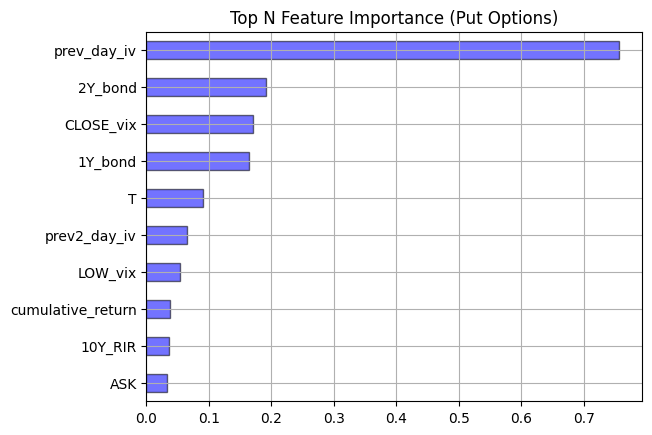

In [ ]:


import pandas as pd

# Get predictions
pred_y = best_model_call.predict(combined_x_c)

# Calculate mean squared error
mse_score = mean_squared_error(combined_y_c, pred_y)

# Assuming 'importance' is a list or array of feature importances
# Create a DataFrame with feature importance scores
feature_importance_networks = pd.DataFrame({
    'feature': combined_x_c.columns,  # Assuming feature names come from 'combined_x_p'
    'importance': importance  # Assuming 'importance' is a list or array of the same length as the number of features
})

# Print the MSE score (separately from the feature importances)
print(f"Mean Squared Error (MSE): {mse_score}")

# Sort by 'importance' in descending order
sorted_importance_c = feature_importance_networks.sort_values(by='importance', ascending=False)

# Display sorted feature importances
(sorted_importance_c)



import matplotlib.pyplot as plt

def plot_feature_importance_barplot(sorted_importance, top_n=5):
    """
    Create a horizontal bar plot showing the top N feature importance.

    Parameters:
    sorted_importance (pd.DataFrame): Sorted feature importance DataFrame.
    top_n (int): Number of top features to plot.
    """
    # Select the top N features based on importance
    top_features = sorted_importance.head(top_n)

    # Sort the top N features by importance for plotting
    top_features = top_features.sort_values(by='importance', ascending=True)

    # Plot the top N feature importance
    plt.figure(figsize=(10, 6))
    ax = top_features.plot(kind='barh', x='feature', y='importance', color='blue', alpha=0.55, edgecolor='black', linewidth=1)
    
    # Remove the y-label
    ax.set_ylabel('')
    
    # Remove the legend
    ax.get_legend().remove()
    
    # Add grid and title
    plt.grid(True)
    ax.set_title('Top N Feature Importance (Put Options)')
    
    # plt.tight_layout()  # Optional: for better layout
    plt.show()

# Example usage: Plot the top 5 features from Put options data
plot_feature_importance_barplot(sorted_importance_c, top_n=10)
